## 加载工具包

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

## 读取并查看数据

In [2]:
root_dir = "data"
# 载入数据集
train = pd.read_csv('%s/%s' % (root_dir, 'labeledTrainData.tsv'), header=0, delimiter="\t", quoting=1)
test = pd.read_csv('%s/%s' % (root_dir, 'testData.tsv'), header=0, delimiter="\t", quoting=1)

print(train.shape)
print(train.columns.values)
print(train.head(3))
print(test.head(3))

(25000, 3)
['id' 'sentiment' 'review']
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...


## 去除HTML标签+数字+全部小写

In [3]:
# 去除评论中的HTML标签
print('\n处理前: \n', train['review'][0])

example1 = BeautifulSoup(train['review'][0], "html.parser")

import re
# Use regular expressions to do a find-and-replace
letters_only = re.sub('[^a-zA-Z]',  # 搜寻的pattern
                      ' ',           # 用来替代的pattern(空格)
                      example1.get_text())  # 待搜索的text 

print(letters_only)
lower_case = letters_only.lower()  # Convert to lower case
words = lower_case.split()  # Split into word

print('\n处理后: \n', words)


处理前: 
 With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it fina

In [4]:
def review_to_wordlist(review):
    '''
    把IMDB的评论转成词序列
    参考：http://blog.csdn.net/longxinchen_ml/article/details/50629613
    '''
    # 去掉HTML标签，拿到内容
    review_text = BeautifulSoup(review, "html.parser").get_text()
    # 用正则表达式取出符合规范的部分
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    # 小写化所有的词，并转成词list
    words = review_text.lower().split()
    # 返回words
    return words

# 预处理数据
label = train['sentiment']
train_data = []
for i in range(len(train['review'])):
    train_data.append(' '.join(review_to_wordlist(train['review'][i])))
test_data = []
for i in range(len(test['review'])):
    test_data.append(' '.join(review_to_wordlist(test['review'][i])))

# 预览数据
print(train_data[0], '\n')
print(test_data[0])

with all this stuff going down at the moment with mj i ve started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him the actual feature film bit when it finally starts is only on for minutes or so

## 特征工程

把文本转换为向量，有几种常见的文本向量处理方法，比如：

* 单词计数
* TF-IDF向量
* Word2vec向量

#### TF-IDF向量

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
# 参考：http://blog.csdn.net/longxinchen_ml/article/details/50629613

"""
min_df: 最小支持度为2（词汇出现的最小次数）
max_features: 默认为None，可设为int，对所有关键词的term frequency进行降序排序，只取前max_features个作为关键词集
strip_accents: 将使用ascii或unicode编码在预处理步骤去除raw document中的重音符号
analyzer: 设置返回类型
token_pattern: 表示token的正则表达式，需要设置analyzer == 'word'，默认的正则表达式选择2个及以上的字母或数字作为token，标点符号默认当作token分隔符，而不会被当作token
ngram_range: 词组切分的长度范围
use_idf: 启用逆文档频率重新加权
use_idf：默认为True，权值是tf*idf，如果设为False，将不使用idf，就是只使用tf，相当于CountVectorizer了。
smooth_idf: idf平滑参数，默认为True，idf=ln((文档总数+1)/(包含该词的文档数+1))+1，如果设为False，idf=ln(文档总数/包含该词的文档数)+1
sublinear_tf: 默认为False，如果设为True，则替换tf为1 + log(tf)
stop_words: 设置停用词，设为english将使用内置的英语停用词，设为一个list可自定义停用词，设为None不使用停用词，设为None且max_df∈[0.7, 1.0)将自动根据当前的语料库建立停用词表
"""
tfidf = TFIDF(min_df=2,
           max_features=None,
           strip_accents='unicode',
           analyzer='word',
           token_pattern=r'\w{1,}',
           ngram_range=(1,3),  # 二元文法模型
           use_idf=1,
           smooth_idf=1,
           sublinear_tf=1,
           stop_words = 'english') # 去掉英文停用词

# 合并训练和测试集以便进行TFIDF向量化操作
data_all = train_data + test_data
len_train = len(train_data)

tfidf.fit(data_all)
data_all = tfidf.transform(data_all)
# 恢复成训练集和测试集部分
train_x = data_all[:len_train]
test_x = data_all[len_train:]
print('TF-IDF处理结束.')

print("train: \n", np.shape(train_x[0]))
print("test: \n", np.shape(test_x[0]))

TF-IDF处理结束.
train: 
 (1, 810866)
test: 
 (1, 810866)


## 朴素贝叶斯模型+交叉验证

In [6]:
# 朴素贝叶斯训练

from sklearn.naive_bayes import MultinomialNB as MNB

model_NB = MNB() # (alpha=1.0, class_prior=None, fit_prior=True)
# 为了在预测的时候使用
model_NB.fit(train_x, label)

from sklearn.model_selection import cross_val_score
import numpy as np

print("多项式贝叶斯分类器10折交叉验证得分:  \n", cross_val_score(model_NB, train_x, label, cv=10, scoring='roc_auc'))
print("\n多项式贝叶斯分类器10折交叉验证得分: ", np.mean(cross_val_score(model_NB, train_x, label, cv=10, scoring='roc_auc')))
test_predicted = np.array(model_NB.predict(test_x))
print('保存结果...')

submission_df = pd.DataFrame({'id': test['id'].values, 'sentiment': test_predicted})
print(submission_df.head(10))
submission_df.to_csv('submission_nb.csv', index = False)

print('结束.')

多项式贝叶斯分类器10折交叉验证得分:  
 [0.95134592 0.94728448 0.951648   0.94707712 0.95122816 0.94939968
 0.95240704 0.95434432 0.94438528 0.94930816]

多项式贝叶斯分类器10折交叉验证得分:  0.949842816
保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
5    2913_8          1
6    4396_1          0
7     395_2          0
8   10616_1          0
9    9074_9          1
结束.


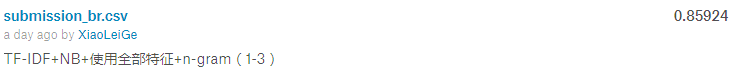

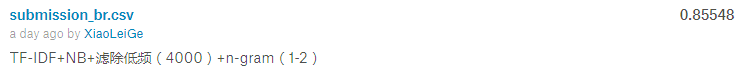

## 逻辑回归模型+网格搜索

In [7]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

# 设定grid search的参数
grid_values = {'C': [1, 15, 30, 50]}  
# 设定打分为roc_auc
"""
penalty: l1 or l2, 用于指定惩罚中使用的标准。
"""
model_LR = GridSearchCV(LR(penalty='l2', dual=True, random_state=0), grid_values, scoring='roc_auc', cv=20)
model_LR.fit(train_x, label)
# 20折交叉验证
# GridSearchCV(cv=20, 
#         estimator=LR(C=1.0, 
#             class_weight=None, 
#             dual=True, 
#             fit_intercept=True, 
#             intercept_scaling=1, 
#             penalty='l2', 
#             random_state=0, 
#             tol=0.0001),
#         fit_params={}, 
#         iid=True,
#         n_jobs=1,
#         param_grid={'C': [30]}, 
#         pre_dispatch='2*n_jobs',
#         refit=True,
#         scoring='roc_auc', 
#         verbose=0)

# 输出结果
print(model_LR.grid_scores_, '\n', model_LR.best_params_, model_LR.best_params_)
print(model_LR.cv_results_, '\n', model_LR.best_params_, model_LR.best_score_)

model_LR = LR(penalty='l2', dual=True, random_state=0)
model_LR.fit(train_x, label)

test_predicted = np.array(model_LR.predict(test_x))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(10))
submission_df.to_csv('submission_lr.csv',columns = ['id','sentiment'], index = False)
print('结束.')

{'mean_fit_time': array([0.67344999, 1.82100004, 2.50764998, 3.30745001]), 'std_fit_time': array([0.1394455 , 0.37063618, 0.43773457, 0.81004566]), 'mean_score_time': array([0.00285003, 0.00339999, 0.0028    , 0.00299996]), 'std_score_time': array([0.00085289, 0.00265323, 0.00050992, 0.00256904]), 'param_C': masked_array(data=[1, 15, 30, 50],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1}, {'C': 15}, {'C': 30}, {'C': 50}], 'split0_test_score': array([0.95273728, 0.95990784, 0.960192  , 0.9602816 ]), 'split1_test_score': array([0.96081408, 0.96953856, 0.96975104, 0.96994816]), 'split2_test_score': array([0.9583616 , 0.96794112, 0.96825856, 0.96836352]), 'split3_test_score': array([0.95249152, 0.96079104, 0.96123136, 0.96137984]), 'split4_test_score': array([0.96460288, 0.9721088 , 0.9724672 , 0.97263104]), 'split5_test_score': array([0.95881216, 0.96733184, 0.96779008, 0.96797184]), 'split6_test_score': array([0.9567

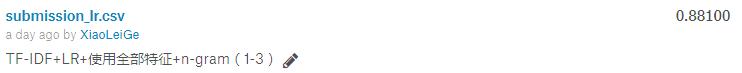

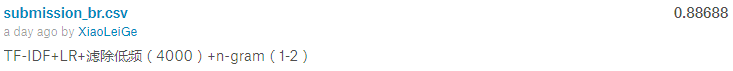

## SVM模型

In [8]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(train_x, label)

test_predicted = np.array(svm.predict(test_x))
print('保存结果...')
submission_df = pd.DataFrame(data ={'id': test['id'], 'sentiment': test_predicted})
print(submission_df.head(10))
submission_df.to_csv('submission_svm.csv',columns = ['id','sentiment'], index = False)
print('结束.')

保存结果...
         id  sentiment
0  12311_10          1
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          1
5    2913_8          1
6    4396_1          0
7     395_2          0
8   10616_1          0
9    9074_9          0
结束.


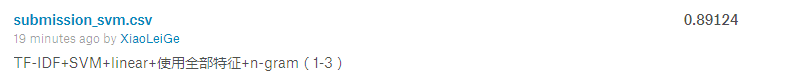